# Elastic Net Regressor


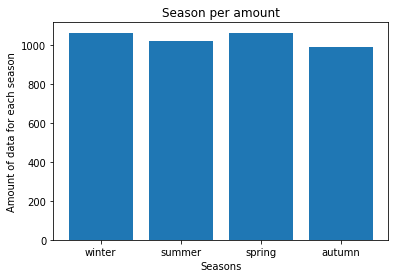

Index(['date', 'temperaturemin', 'temperaturemax', 'precipitation', 'snowfall',
       'snowdepth', 'avgwindspeed', 'fastest2minwinddir',
       'fastest2minwindspeed', 'fastest5secwinddir', 'fastest5secwindspeed',
       'fog', 'fogheavy', 'mist', 'rain', 'fogground', 'ice', 'glaze',
       'drizzle', 'snow', 'freezingrain', 'smokehaze', 'thunder', 'highwind',
       'hail', 'blowingsnow', 'dust', 'freezingfog', 'season'],
      dtype='object')

In [84]:
import pandas as pd

# As colunas estão separadas pelo símbolo ';' #. 
weather_history = pd.read_csv('rdu-weather-history.csv', parse_dates=['date'], sep=';')


# Substituindo as string por números binários -- No = 0.0 e Yes = 1.0
weather_history = weather_history.replace('No', 0.0)
weather_history = weather_history.replace('Yes', 1.0)

from sklearn.preprocessing import Imputer
import numpy as np

#Substituindo os valores nulos pela média dos valores referentes a feature
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
weather_history[['temperaturemin']] = imputer.fit_transform(weather_history[['temperaturemin']])
weather_history[['temperaturemax']] = imputer.fit_transform(weather_history[['temperaturemax']])
weather_history[['precipitation']] = imputer.fit_transform(weather_history[['precipitation']])
weather_history[['snowfall']] = imputer.fit_transform(weather_history[['snowfall']])
weather_history[['snowdepth']] = imputer.fit_transform(weather_history[['snowdepth']])
weather_history[['avgwindspeed']] = imputer.fit_transform(weather_history[['avgwindspeed']])
weather_history[['fastest2minwinddir']] = imputer.fit_transform(weather_history[['fastest2minwinddir']])
weather_history[['fastest2minwindspeed']] = imputer.fit_transform(weather_history[['fastest2minwindspeed']])
weather_history[['fastest5secwinddir']] = imputer.fit_transform(weather_history[['fastest5secwinddir']])
weather_history[['fastest5secwindspeed']] = imputer.fit_transform(weather_history[['fastest5secwindspeed']])

season_array = []

for date in weather_history['date']:
    if int(date.strftime('%m%d')) >= 1221 or int(date.strftime('%m%d')) <= 319:
        season = 0 #'winter'
    elif int(date.strftime('%m%d')) >= 320 and int(date.strftime('%m%d')) <= 620:
        season = 1 #'spring'
    elif int(date.strftime('%m%d')) >= 621 and int(date.strftime('%m%d')) <= 921:
        season = 2 #'summer'
    elif int(date.strftime('%m%d')) >= 922 and int(date.strftime('%m%d')) <= 1220:
        season = 3 #'autumn'    
    
    season_array.append(season)

weather_history['season'] = season_array
weather_history = weather_history.sort_values('date', ascending=True)
winter_weather_history = weather_history[weather_history['season'] == 0]
spring_weather_history = weather_history[weather_history['season'] == 1]
summer_weather_history = weather_history[weather_history['season'] == 2]
autumn_weather_history = weather_history[weather_history['season'] == 3]
len_winter = len(winter_weather_history['date'])
len_summer = len(summer_weather_history['date'])
len_spring = len(spring_weather_history['date'])
len_autumn = len(autumn_weather_history['date'])

X = ['winter', 'summer', 'spring', 'autumn']
Y = [len_winter, len_summer, len_spring, len_autumn]

import matplotlib.pyplot as plt

plt.bar(X, Y)
plt.xlabel('Seasons')
plt.ylabel('Amount of data for each season')
plt.title('Season per amount')
plt.show()

weather_history.columns

(0, 'date')


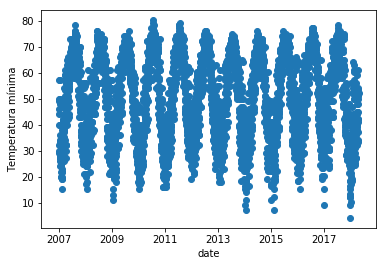

(1, 'temperaturemax')


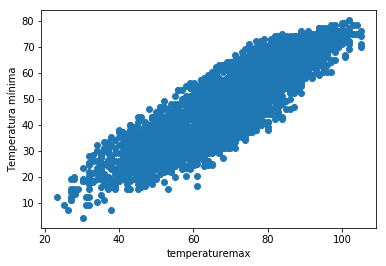

(2, 'precipitation')


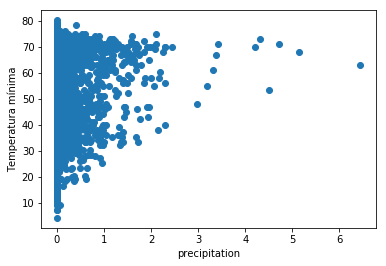

(3, 'snowfall')


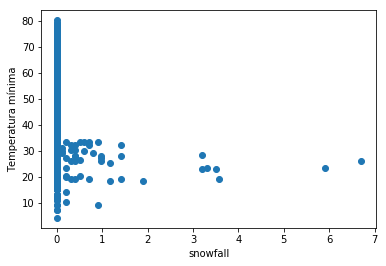

(4, 'snowdepth')


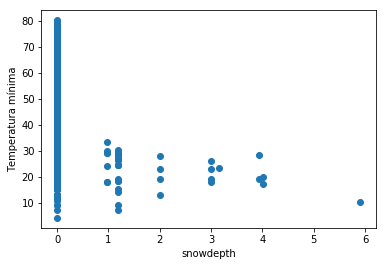

(5, 'avgwindspeed')


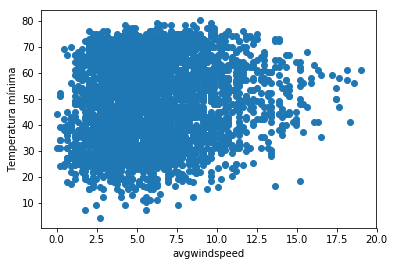

(6, 'fastest2minwinddir')


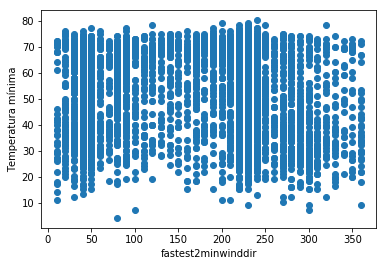

(7, 'fastest2minwindspeed')


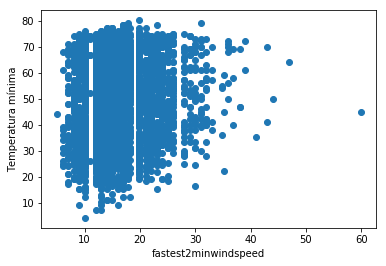

(8, 'fastest5secwinddir')


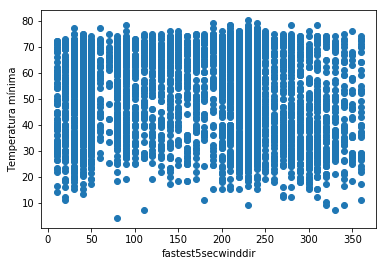

(9, 'fastest5secwindspeed')


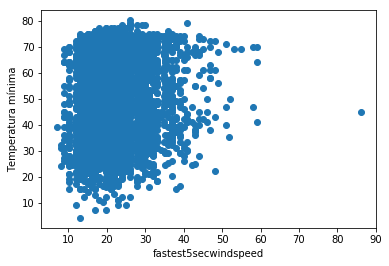

(27, 'season')


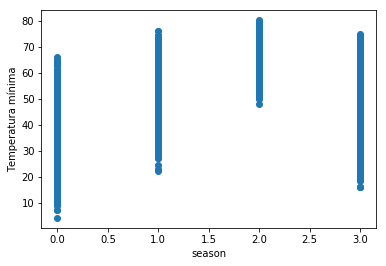

In [103]:
X = weather_history.drop('temperaturemin', axis=1).values
y = weather_history['temperaturemin'].values

weather_history_no_min = weather_history.drop('temperaturemin', axis=1)

X_new = weather_history_no_min
for i in enumerate(weather_history_no_min.columns):
    related_value = weather_history_no_min[i[1]].values
    if not np.array_equal(np.unique(related_value), [0, 1.]):
        print(i)
        plt.scatter(related_value, y)
        plt.ylabel(str('Temperatura mínima'))
        plt.xlabel(str(i[1]))
        plt.show()
    else:
        X_new = X_new.drop(i[1], axis=1)

In [147]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

X_new_new = X_new.drop('date', axis=1)
X_new_new = X_new_new.drop('fastest5secwinddir', axis=1)
X_new_new = X_new_new.drop('season', axis=1)
X_new_new = X_new_new.drop('fastest2minwinddir', axis=1)
X_new_new = X_new_new.drop('snowdepth', axis=1)
X_new_new = X_new_new.drop('snowfall', axis=1)
X_new_new = X_new_new.values
regr = ElasticNet(random_state=0)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_new_new, y, test_size=0.25, random_state=42)
regr.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [158]:
y_test = y_test.reshape(-1, 1)
regr.predict(y_test)
regr.coef_

ValueError: shapes (1035,1) and (5,) not aligned: 1 (dim 1) != 5 (dim 0)